In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import shap
import gower

/home/filippo/code/sciviz/assignment-01/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/ilpd-clustered.csv')

In [3]:
df

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,...,Clusters_KProto_k5,Clusters_GMM_k2,Clusters_GMM_k4,Clusters_GMM_k7,Clusters_HDBScan_MinClusters5,Clusters_HDBScan_MinClusters6,Clusters_Spectral_k2,Clusters_Spectral_k4,Clusters_Spectral_k6,Label
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,...,0,0,0,0,1,0,1,1,0,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,...,3,0,1,1,-1,-1,0,2,2,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,...,0,0,1,1,-1,0,0,3,3,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,...,0,0,0,0,1,0,0,3,3,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,...,0,0,0,1,1,0,0,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,...,0,0,1,1,1,0,0,3,5,2
575,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,...,0,0,0,0,1,0,0,0,4,1
576,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,...,0,0,0,0,1,0,0,3,3,1
577,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,...,0,0,0,0,1,0,0,0,1,1


In [5]:
# Features (drop cluster columns and label)
X_features = df.drop(columns=[col for col in df.columns if col.startswith("Clusters_")]+['Label'])

# Cluster labels as target
y_target = df['Clusters_Spectral_k6']

### Option 1: Direct Dimensionality Reduction

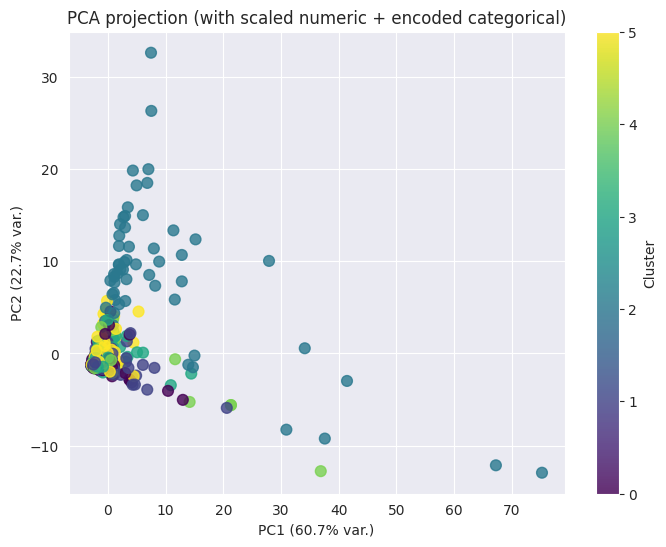

In [8]:
# Identify column types
num_cols = X_features.select_dtypes(include=['number']).columns
cat_cols = X_features.select_dtypes(exclude=['number']).columns

# Preprocessing pipeline: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

# Apply transformation
X_preprocessed = preprocessor.fit_transform(X_features)

# Dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)


# Plot clusters
plt.figure(figsize=(8, 6))

# xlims = np.percentile(X_pca[:, 0], [1, 99])
# ylims = np.percentile(X_pca[:, 1], [1, 99])
# plt.xlim(xlims)
# plt.ylim(ylims)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_target, cmap='viridis', s=60, alpha=0.8)
plt.title("PCA projection (with scaled numeric + encoded categorical)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)")
plt.colorbar(scatter, label="Cluster")
plt.show()

### Option 2: Dimensionality Reduction on the Gower Matrix, using Spectral Embedding

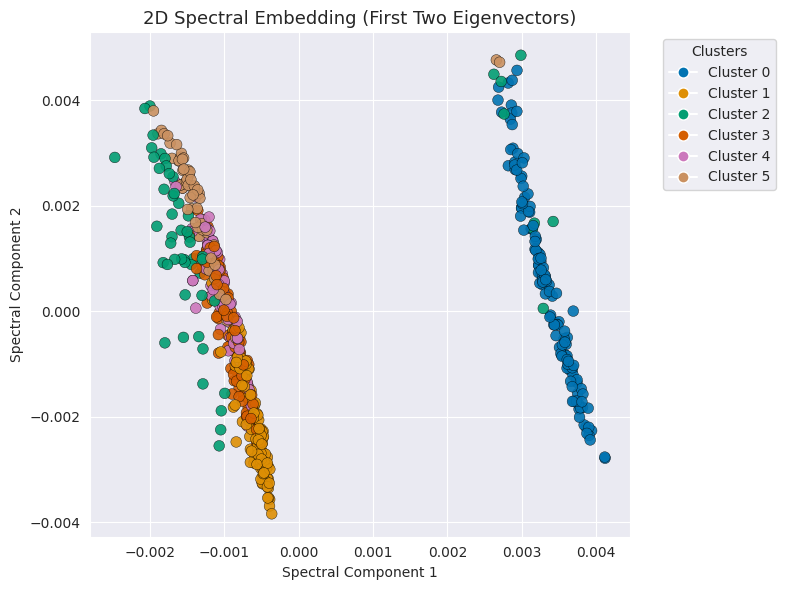

In [7]:
gower_dist = gower.gower_matrix(X_features)
similarity = 1 - gower_dist  # affinity matrix

# --- Compute 2D Spectral Embedding ---
embedding_2d = SpectralEmbedding(
    n_components=2,
    affinity='precomputed',
    random_state=42
).fit_transform(similarity)

# --- Prepare colors for clusters ---
n_clusters = len(np.unique(y_target))
colors = sns.color_palette("colorblind", n_colors=n_clusters)

# --- Plot 2D spectral embedding ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=y_target,
    cmap=mcolors.ListedColormap(colors),
    s=60, alpha=0.9, edgecolor='k', linewidth=0.3
)

# --- Legend ---
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {c}',
               markerfacecolor=colors[i], markersize=8)
    for i, c in enumerate(sorted(np.unique(y_target)))
]
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Aesthetics ---
plt.title("2D Spectral Embedding (First Two Eigenvectors)", fontsize=13)
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.tight_layout()
plt.show()

### Option 3: 2-step visualization using Spectral Embedding (10D to 6D) and then t-SNE (6D to 2D)

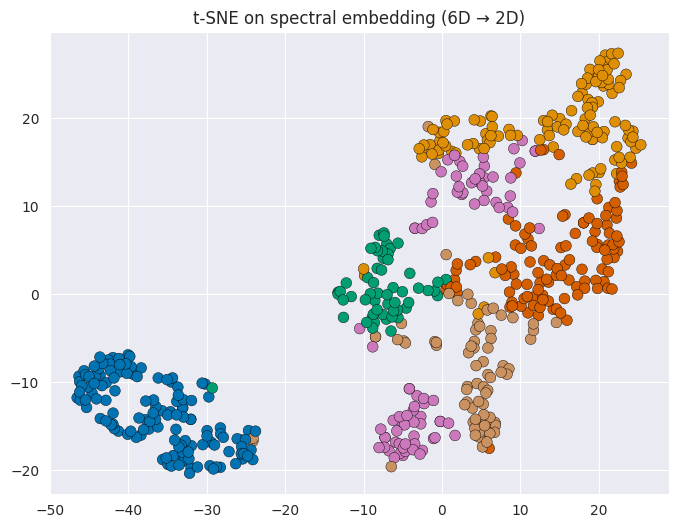

In [6]:
# compute similarity as you already do
gower_dist = gower.gower_matrix(X_features)
similarity = 1 - gower_dist

# spectral embedding with more components (keep some extra info)
spec = SpectralEmbedding(n_components=6, affinity='precomputed', random_state=42)
emb6 = spec.fit_transform(similarity)

# optional: row-normalize (common for normalized Laplacian / spectral clustering)
emb6_norm = normalize(emb6, norm='l2', axis=1)

n_clusters = len(np.unique(y_target))
colors = sns.color_palette("colorblind", n_colors=n_clusters)

# emb6 or emb6_norm from above
tsne = TSNE(n_components=2, init='pca', perplexity=30, random_state=42)
emb2_tsne = tsne.fit_transform(emb6_norm)

plt.figure(figsize=(8,6))
plt.scatter(emb2_tsne[:,0], emb2_tsne[:,1], c=y_target,
            cmap=mcolors.ListedColormap(colors), s=60, edgecolor='k', linewidth=0.3)
plt.title("t-SNE on spectral embedding (6D → 2D)")
plt.show()